In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

In [ ]:
# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
glove_embeddings = loadGloveModel("/content/drive/MyDrive/text-to-image/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
# Setting up the paths
train_data_path = ""
train_images_path = ""
train_captions_path = ""

The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# Configuration
#DATA_PATH = train_images_path
MODEL_PATH = "/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

## Data Pre-Processing 

Now we load and preprocess the images. CoLab took around an hour to process, hence we store the processed file as a binary.  This way we can simply reload the processed training data to quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
# Image set has 8,188 images. 
# Because of this time needed, we save a Numpy preprocessed file.

training_binary_path = os.path.join("/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...
Saving training image 100099.npy
Image preprocess time: 0:01:03.71
Saving training image 100199.npy
Image preprocess time: 0:02:09.42
Saving training image 100299.npy
Image preprocess time: 0:03:12.96
Saving training image 100399.npy
Image preprocess time: 0:04:21.10
Saving training image 100499.npy
Image preprocess time: 0:05:25.98
Saving training image 100599.npy
Image preprocess time: 0:06:31.56
Saving training image 100699.npy
Image preprocess time: 0:07:38.62
Saving training image 100799.npy
Image preprocess time: 0:08:42.61
Saving training image 100899.npy
Image preprocess time: 0:09:48.97
Saving training image 100999.npy
Image preprocess time: 0:10:52.36
Saving training image 101099.npy
Image preprocess time: 0:12:02.87
Saving training image 101199.npy
Image preprocess time: 0:13:10.82
Saving training image 101299.npy
Image preprocess time: 0:14:14.24
Saving training image 101399.npy
Image preprocess time: 0:15:17.00
Saving training image 101499.npy
Im

Now we load and preprocess the captions. CoLab took around an hour to process, hence we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [ ]:
text_path = "/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    # print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):                                                          
      x = data[d].lower()
      #x = x.replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

In [ ]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/images/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

In [ ]:
# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]

NameError: ignored

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma , petals are white inc..."
1,"this flower has bright purple , spiky petals ..."
2,this flower has a row of white petals with the...
3,"this flower is white and blue in color , with..."
4,this flower has petals that are green with str...


In [ ]:
captions[:10]

['prominent purple stigma , petals are white inc olor',
 'this flower has bright purple ,  spiky petals ,  and greenish sepals below them . ',
 'this flower has a row of white petals with the multi - colored stamens and a pistil at the centre',
 'this flower is white and blue in color ,  with petals that are oval shaped . ',
 'this flower has petals that are green with stringy purple stamen',
 'this flower is blue and green in color ,  with petals that are oval shaped . ',
 'the petals of the flower are bright blue with white lines ,  and the stamen is bright green with black dots . ',
 'the flower has stamen and the petals are green in color . ',
 'this flower has green petals and purple and green stamen . ',
 'the flower shown has green pollen tubes with green sepal and blue petals']

In [ ]:
df_captions.to_csv("/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/text_c10/captions.csv",index=None)

## Loading and combining numpys

In [ ]:
embedding_binary_path = '/content/drive/MyDrive/text-to-image/images/embedding_npy/embedding_data.npy'

In [ ]:
caption_embeddings = np.load(embedding_binary_path)

In [ ]:
caption_embeddings.shape

In [ ]:
image_binary_path = "/content/drive/MyDrive/text-to-image/images/npy64/"
images = os.listdir(image_binary_path)

In [ ]:
images[-1]

In [ ]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_100099.npy
training_data_64_64_100399.npy
training_data_64_64_100299.npy
training_data_64_64_100499.npy
training_data_64_64_100699.npy
training_data_64_64_100599.npy
training_data_64_64_100899.npy
training_data_64_64_100999.npy
training_data_64_64_100799.npy
training_data_64_64_101099.npy
training_data_64_64_101199.npy
training_data_64_64_101399.npy
training_data_64_64_101299.npy
training_data_64_64_101499.npy
training_data_64_64_101699.npy
training_data_64_64_101799.npy
training_data_64_64_101599.npy
training_data_64_64_101999.npy
training_data_64_64_101899.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102399.npy
training_data_64_64_102499.npy
training_data_64_64_102299.npy
training_data_64_64_102699.npy
training_data_64_64_102599.npy
training_data_64_64_102799.npy
training_data_64_64_102999.npy
training_data_64_64_102899.npy
training_data_64_64_103199.npy
training_data_64_64_103099.npy
training_data_64_64_103399.npy
training

In [ ]:
final_images.shape

(8100, 64, 64, 3)

In [ ]:
df_captions = pd.read_csv("/content/drive/MyDrive/text-to-image/text_c10/captions.csv")

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [ ]:
caption_embeddings.shape

(8100, 300)

In [ ]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Data Modeling

Defining the Generator and Discriminator

In [ ]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

Function to save image samples generated

In [ ]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = "/content/drive/MyDrive/text-to-image/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
generator.load_weights("/content/drive/MyDrive/text-to-image/model/text_to_image_generator_cub_character.h5")

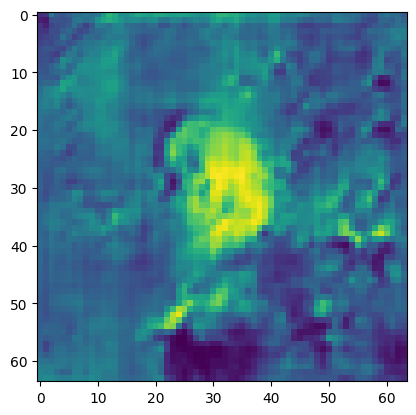

In [ ]:
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
discriminator.load_weights('/content/drive/MyDrive/text-to-image/model/text_to_image_disc_cub_character.h5')

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=2e-4,
#     decay_steps=100,
#     decay_rate=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
# Function that executes training process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)
    
    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
train(list(train_dataset.as_numpy_iterator()), 500)

epoch start...
now
Epoch 1, gen loss=0.7686348557472229,disc loss=1.5495121479034424, 0:00:16.03
model saved
epoch start...
now
Epoch 2, gen loss=0.7586959600448608,disc loss=1.4737610816955566, 0:00:13.88
model saved
epoch start...
now
Epoch 3, gen loss=0.7599285840988159,disc loss=1.4424796104431152, 0:00:13.88
model saved
epoch start...
now
Epoch 4, gen loss=0.7321832776069641,disc loss=1.4321304559707642, 0:00:13.89
model saved
epoch start...
now
Epoch 5, gen loss=0.7370102405548096,disc loss=1.4232256412506104, 0:00:13.90
model saved
epoch start...
now
Epoch 6, gen loss=0.7280808091163635,disc loss=1.4163377285003662, 0:00:13.89
model saved
epoch start...
now
Epoch 7, gen loss=0.7229128479957581,disc loss=1.4120633602142334, 0:00:13.89
model saved
epoch start...
now
Epoch 8, gen loss=0.726793110370636,disc loss=1.4074561595916748, 0:00:13.89
model saved
epoch start...
now
Epoch 9, gen loss=0.719771683216095,disc loss=1.4027323722839355, 0:00:13.89
model saved
epoch start...
now
Ep

## Results

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)
 

In [ ]:
test_image("this flower is red in color with tiny round shaped petals",1)

1/1 [==============================] - 0s 31ms/step


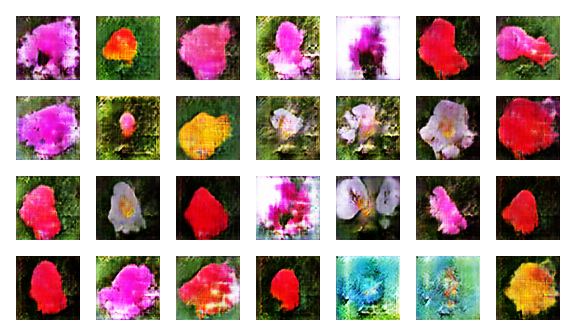

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/text-to-image/output_64_character_extended/train-1.png')

In [ ]:
test_image("this flower is green in color with oval shaped petals",2)

1/1 [==============================] - 1s 1s/step


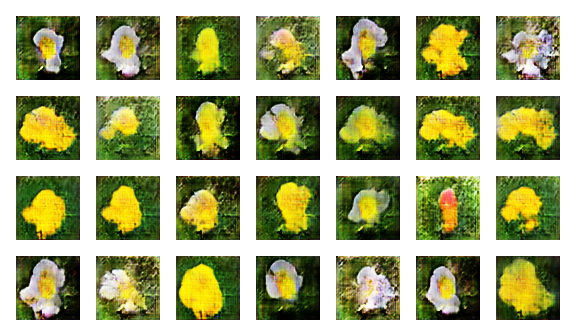

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/text-to-image/output_64_character_extended/train-2.png')

In [ ]:
test_image("this flower is purple in color with oval shaped petals",100)

1/1 [==============================] - 1s 1s/step


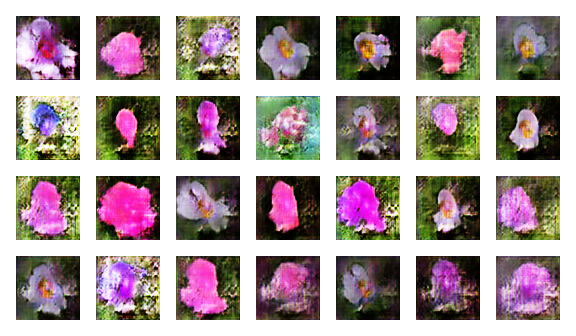

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/text-to-image/output_64_character_extended/train-100.png')

In [ ]:
test_image("this flower is white in color with yellow stigma",100)

1/1 [==============================] - 0s 20ms/step


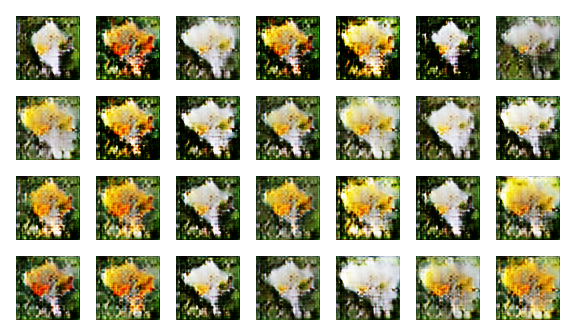

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/text-to-image/output_64_character_extended/train-100.png')